# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

# magic word for producing visualizations in notebook
%matplotlib inline

pd.options.display.max_rows = None
pd.options.display.max_columns = None

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.

azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')
print("AZDIAS shape:", azdias.shape)
azdias.head()

# Load in the feature summary file.

feature_summary = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')
print("Feature summary shape:", feature_summary.shape)
feature_summary.head()


AZDIAS shape: (891221, 85)
Feature summary shape: (85, 4)


,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).

print("AZDIAS shape (rows, columns):", azdias.shape)

print("\nPreview of the first 5 rows:")
display(azdias.head())

print("\nData types and non-null counts:")
display(azdias.info())







AZDIAS shape (rows, columns): (891221, 85)

Preview of the first 5 rows:


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,4,0,10.0,0,-1,15.0,4.0,2.0,2.0,1.0,1.0,0,0,5.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,-1,NaN,NaN,-1,3,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,1,1996,10.0,0,3,21.0,6.0,5.0,3.0,2.0,1.0,1,14,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,3,1.0,0.0,2,5,0.0,2.0,0.0,6.0,NaN,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,W,4.0,8,8A,51,0.0,0.0,0.0,2.0,5.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,1,1979,10.0,1,3,3.0,1.0,1.0,1.0,3.0,2.0,1,15,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,2,0.0,0.0,1,5,17.0,1.0,0.0,4.0,NaN,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,W,2.0,4,4C,24,1.0,3.0,1.0,0.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,6,1957,1.0,0,2,0.0,0.0,0.0,0.0,9.0,4.0,1,8,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,1,0.0,0.0,1,3,13.0,0.0,0.0,1.0,NaN,NaN,9.0,1.0,0.0,1.0,4.0,1997.0,W,7.0,2,2A,12,4.0,1.0,0.0,0.0,1.0,4.0,4.0,2.0,6.0,4.0,0.0,4.0,1.0,0.0,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,5,1963,5.0,0,3,32.0,10.0,10.0,5.0,3.0,2.0,1,8,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,2,0.0,0.0,2,4,20.0,4.0,0.0,5.0,1.0,2.0,9.0,3.0,0.0,1.0,4.0,1992.0,W,3.0,6,6B,43,1.0,4.0,1.0,0.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0



Data types and non-null counts:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   AGER_TYP               891221 non-null  int64  
 1   ALTERSKATEGORIE_GROB   891221 non-null  int64  
 2   ANREDE_KZ              891221 non-null  int64  
 3   CJT_GESAMTTYP          886367 non-null  float64
 4   FINANZ_MINIMALIST      891221 non-null  int64  
 5   FINANZ_SPARER          891221 non-null  int64  
 6   FINANZ_VORSORGER       891221 non-null  int64  
 7   FINANZ_ANLEGER         891221 non-null  int64  
 8   FINANZ_UNAUFFAELLIGER  891221 non-null  int64  
 9   FINANZ_HAUSBAUER       891221 non-null  int64  
 10  FINANZTYP              891221 non-null  int64  
 11  GEBURTSJAHR            891221 non-null  int64  
 12  GFK_URLAUBERTYP        886367 non-null  float64
 13  GREEN_AVANTGARDE       891221 non-null  int64  
 14  HEA

None

> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [4]:
# Identify missing or unknown data values and convert them to NaNs.

import numpy as np
import ast

# Create a copy to preserve the original data
azdias_clean = azdias.copy()

# Build a dictionary mapping each column to its list of missing/unknown values
missing_val_map = {}

for _, row in feature_summary.iterrows():
    column = row['attribute']
    raw_missing = row['missing_or_unknown']
    if pd.notnull(raw_missing):
        try:
            # Convert string like "[-1, 0]" to actual list [-1, 0]
            missing_vals = ast.literal_eval(raw_missing)
            missing_val_map[column] = missing_vals
        except:
            # If parsing fails, skip the column
            missing_val_map[column] = []

# Replace the missing values in azdias_clean
for col, missings in missing_val_map.items():
    if col in azdias_clean.columns:
        azdias_clean[col] = azdias_clean[col].replace(missings, np.nan)



In [5]:
missing_percent = azdias_clean.isnull().mean().sort_values(ascending=False)
missing_percent.head(10)  # Show top 10 features with most missing data


TITEL_KZ          0.997576
AGER_TYP          0.769554
KK_KUNDENTYP      0.655967
KBA05_BAUMAX      0.534687
GEBURTSJAHR       0.440203
ALTER_HH          0.348137
KKK               0.177357
REGIOTYP          0.177357
W_KEIT_KIND_HH    0.166051
KBA05_ANTG1       0.149597
dtype: float64

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

Proportion of missing data per column:
TITEL_KZ                 0.997576
AGER_TYP                 0.769554
KK_KUNDENTYP             0.655967
KBA05_BAUMAX             0.534687
GEBURTSJAHR              0.440203
ALTER_HH                 0.348137
KKK                      0.177357
REGIOTYP                 0.177357
W_KEIT_KIND_HH           0.166051
KBA05_ANTG1              0.149597
KBA05_GBZ                0.149597
KBA05_ANTG2              0.149597
KBA05_ANTG3              0.149597
KBA05_ANTG4              0.149597
MOBI_REGIO               0.149597
PLZ8_ANTG2               0.130736
PLZ8_ANTG3               0.130736
PLZ8_BAUMAX              0.130736
PLZ8_ANTG4               0.130736
PLZ8_HHZ                 0.130736
PLZ8_GBZ                 0.130736
PLZ8_ANTG1               0.130736
SHOPPER_TYP              0.124768
HEALTH_TYP               0.124768
VERS_TYP                 0.124768
NATIONALITAET_KZ         0.121536
PRAEGENDE_JUGENDJAHRE    0.121366
KBA13_ANZAHL_PKW         0.118714
ANZ_HAUSH

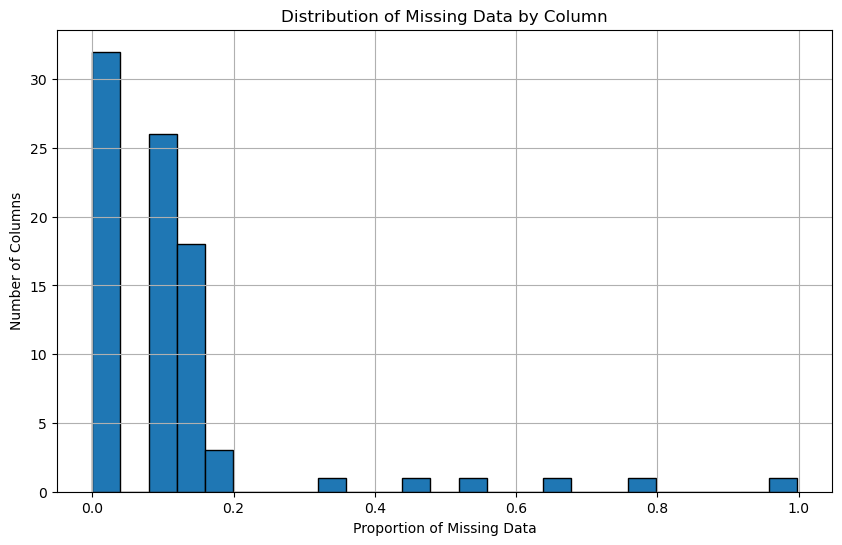


Columns with more than 30% missing data:
TITEL_KZ        0.997576
AGER_TYP        0.769554
KK_KUNDENTYP    0.655967
KBA05_BAUMAX    0.534687
GEBURTSJAHR     0.440203
ALTER_HH        0.348137
dtype: float64


In [6]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.

import matplotlib.pyplot as plt

# Calculate the proportion of missing data per column
missing_percent = azdias_clean.isnull().mean().sort_values(ascending=False)

# Display the proportion of missing data for all columns
print("Proportion of missing data per column:")
print(missing_percent)

# Visualize the distribution of missing data percentages across columns
plt.figure(figsize=(10, 6))
plt.hist(missing_percent, bins=25, edgecolor='black')
plt.title("Distribution of Missing Data by Column")
plt.xlabel("Proportion of Missing Data")
plt.ylabel("Number of Columns")
plt.grid(True)
plt.show()

# Identify columns with more than 30% missing data
missing_outliers = missing_percent[missing_percent > 0.3]
print("\nColumns with more than 30% missing data:")
print(missing_outliers)

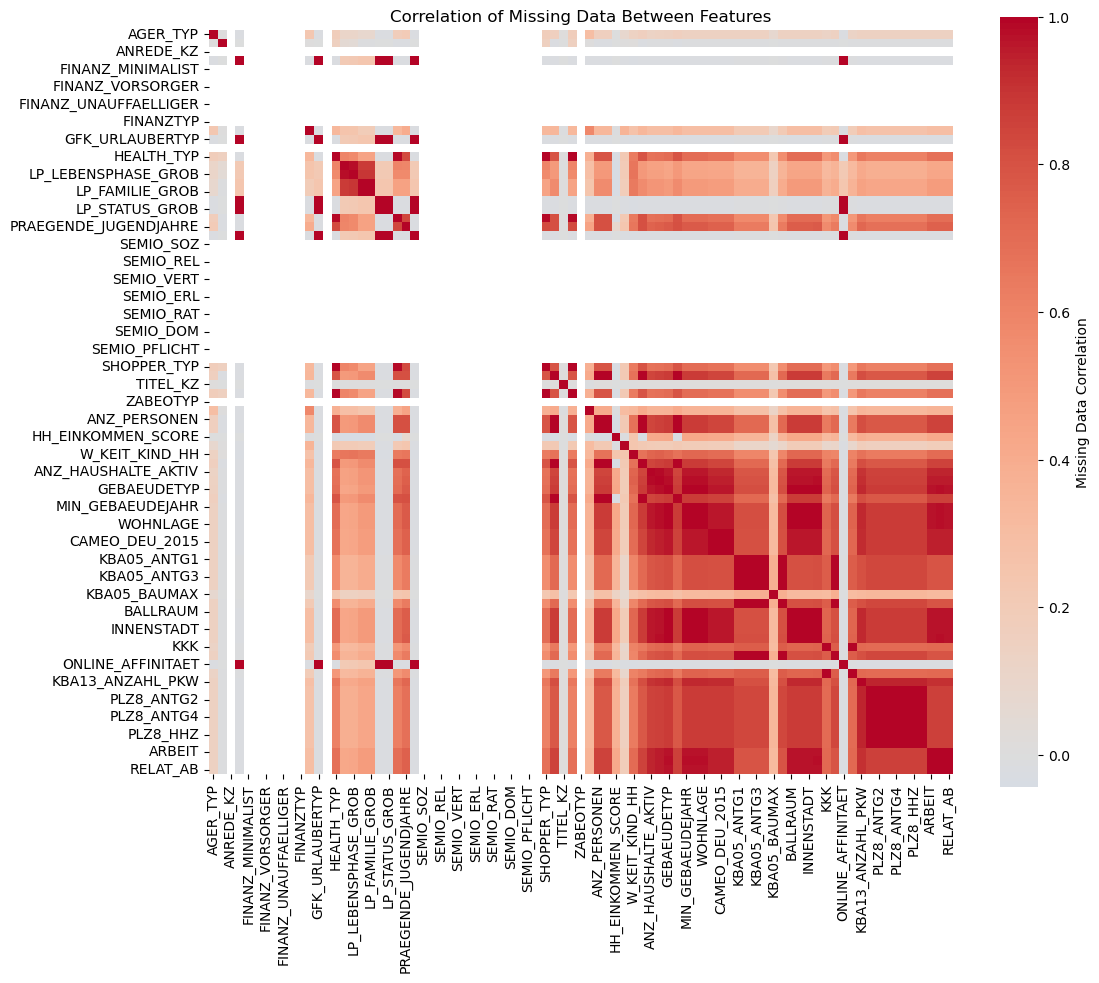

In [7]:
# Investigate patterns in the amount of missing data in each column.

# Create a boolean DataFrame where True indicates missing values
missing_bool = azdias_clean.isnull()

# Calculate correlation matrix of missingness (only among columns with missing data)
missing_corr = missing_bool.corr()

# Plot the heatmap to visualize correlations of missing data between columns
plt.figure(figsize=(12, 10))
sns.heatmap(missing_corr, cmap='coolwarm', center=0, square=True, cbar_kws={'label': 'Missing Data Correlation'})
plt.title('Correlation of Missing Data Between Features')
plt.show()

In [8]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)


# List of columns to drop based on high missing value percentage
cols_to_drop = ['TITEL_KZ', 'AGER_TYP', 'KK_KUNDENTYP', 'KBA05_BAUMAX', 'GEBURTSJAHR', 'ALTER_HH']

# Drop them from the cleaned dataset
azdias_clean.drop(columns=cols_to_drop, inplace=True)



#### Discussion 1.1.2: Assess Missing Data in Each Column

Observations:

Majority of columns have low missingness:
Most columns have less than 20% missing data, with a significant concentration below 10%. This is a positive sign indicating that the dataset is largely complete for most features.

Long tail of high-missing columns:
A few columns exhibit extremely high proportions of missing values, reaching up to 99.75% in the case of TITEL_KZ.

Columns with 0% missing data:
A substantial number of features (e.g., FINANZ_ANLEGER, SEMIO_TRADV, ZABEOTYP, etc.) are fully populated, which may be useful for baseline models or imputation assistance.

Patterns in Missing Values:
The presence of groups of columns with similar missingness percentages (e.g., multiple columns with ~14.96% missingness such as KBA05_ANTG1, KBA05_GBZ, etc.) suggests that these may be related features or derived from the same source.

Demographic-related features like GEBURTSJAHR (birth year) and ALTER_HH (household age) also show a high proportion of missing values, which could be due to privacy concerns or collection limitations.

Columns Removed from Dataset (Missing > 30%):
Based on the threshold of 30% missing data, the following six columns were dropped:

TITEL_KZ – 99.76% missing

AGER_TYP – 76.96% missing

KK_KUNDENTYP – 65.60% missing

KBA05_BAUMAX – 53.47% missing

GEBURTSJAHR – 44.02% missing

ALTER_HH – 34.81% missing

These columns are considered outliers in terms of missing data and would likely introduce bias or complexity in modeling, especially if imputation were attempted.

Conclusion:
By removing these six columns, we reduce the burden of handling excessive missing values and simplify the data preprocessing pipeline. Future steps should include imputation strategies for moderately missing columns and encoding transformations for categorical features.


#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

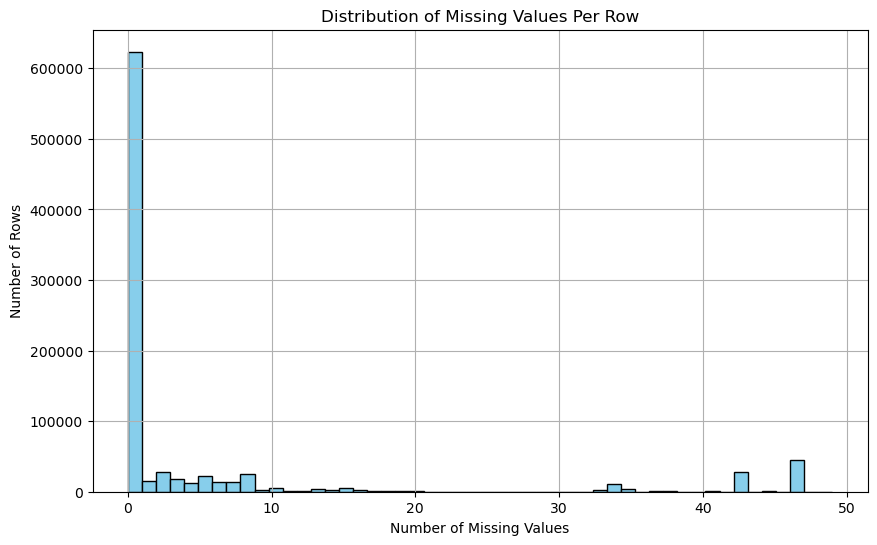

Minimum missing values in a row: 0
Maximum missing values in a row: 49
Average missing values per row: 5.64863821655908


In [9]:
# How much data is missing in each row of the dataset?
import matplotlib.pyplot as plt

# Count the number of missing values in each row
missing_per_row = azdias_clean.isnull().sum(axis=1)

# Plot a histogram of missing value counts per row
plt.figure(figsize=(10, 6))
plt.hist(missing_per_row, bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Missing Values Per Row')
plt.xlabel('Number of Missing Values')
plt.ylabel('Number of Rows')
plt.grid(True)
plt.show()

# Optional: Print some basic stats
print("Minimum missing values in a row:", missing_per_row.min())
print("Maximum missing values in a row:", missing_per_row.max())
print("Average missing values per row:", missing_per_row.mean())



In [10]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

# Set threshold for maximum acceptable missing values in a row
threshold = 15

# Count missing values per row
missing_per_row = azdias_clean.isnull().sum(axis=1)

# Subset with acceptable amount of missing data
azdias_low_missing = azdias_clean[missing_per_row <= threshold].copy()

# Subset with too many missing values
azdias_high_missing = azdias_clean[missing_per_row > threshold].copy()

# Print how many rows are in each subset
print(f"Rows with ≤ {threshold} missing values: {azdias_low_missing.shape[0]}")
print(f"Rows with > {threshold} missing values: {azdias_high_missing.shape[0]}")





Rows with ≤ 15 missing values: 792317
Rows with > 15 missing values: 98904



=== ANZ_PERSONEN ===
Low Missing Values Subset:
  0.0: 32615 (4.1%)
  1.0: 409941 (51.7%)
  2.0: 189329 (23.9%)
  3.0: 92337 (11.7%)
  4.0: 45913 (5.8%)
  nan: 0 (0.0%)
High Missing Values Subset:
  0.0: 1488 (1.5%)
  1.0: 13442 (13.6%)
  2.0: 6141 (6.2%)
  3.0: 2568 (2.6%)
  4.0: 1213 (1.2%)
  nan: 73499 (74.3%)
Note: Remaining categories grouped as 'Other' if not in top 5


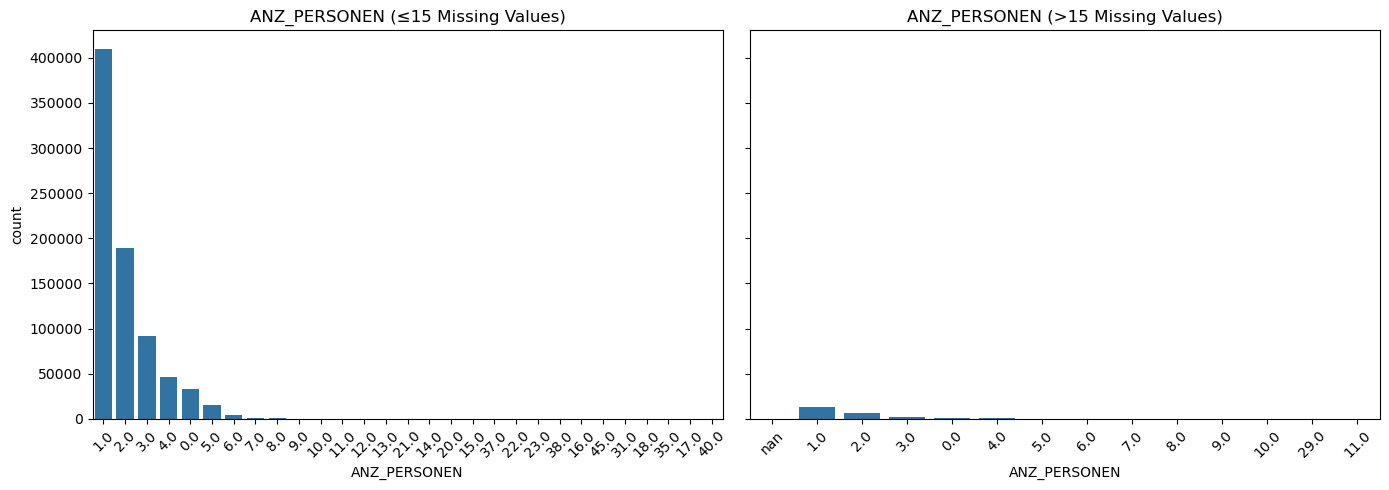


=== HH_EINKOMMEN_SCORE ===
Low Missing Values Subset:
  2.0: 64617 (8.2%)
  3.0: 82733 (10.4%)
  4.0: 138211 (17.4%)
  5.0: 201097 (25.4%)
  6.0: 252662 (31.9%)
  nan: 0 (0.0%)
High Missing Values Subset:
  2.0: 76200 (77.0%)
  3.0: 2072 (2.1%)
  4.0: 1551 (1.6%)
  5.0: 385 (0.4%)
  6.0: 113 (0.1%)
  nan: 18348 (18.6%)
Note: Remaining categories grouped as 'Other' if not in top 5


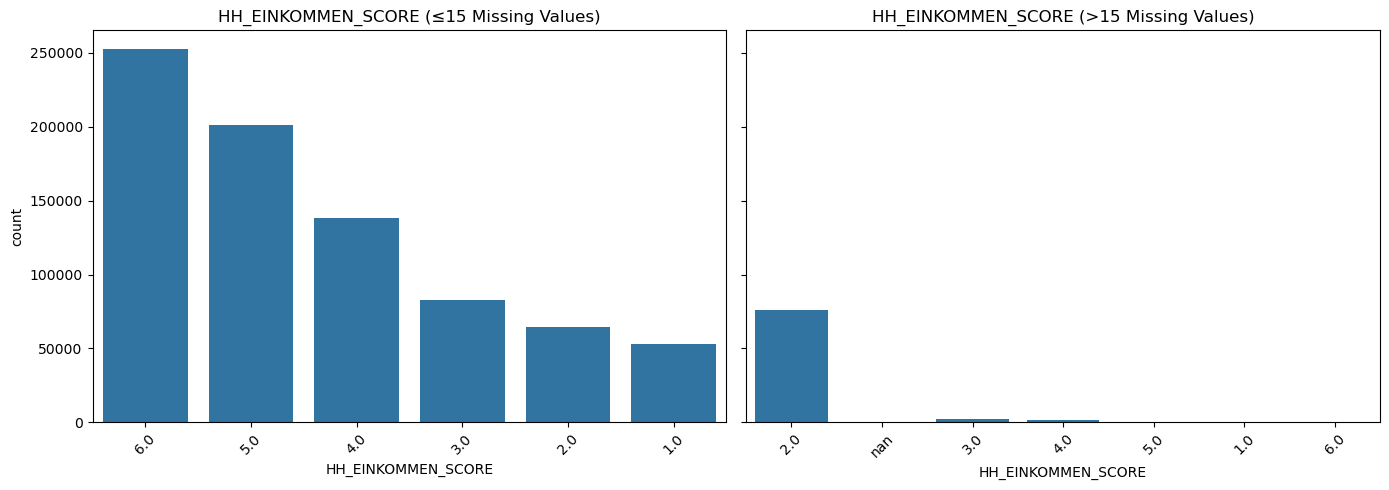


=== KBA05_ANTG1 ===
Low Missing Values Subset:
  0.0: 260973 (32.9%)
  1.0: 161112 (20.3%)
  2.0: 126686 (16.0%)
  3.0: 117731 (14.9%)
  4.0: 91124 (11.5%)
  nan: 34691 (4.4%)
High Missing Values Subset:
  0.0: 76 (0.1%)
  1.0: 112 (0.1%)
  2.0: 39 (0.0%)
  3.0: 31 (0.0%)
  4.0: 13 (0.0%)
  nan: 98633 (99.7%)
Note: Remaining categories grouped as 'Other' if not in top 5


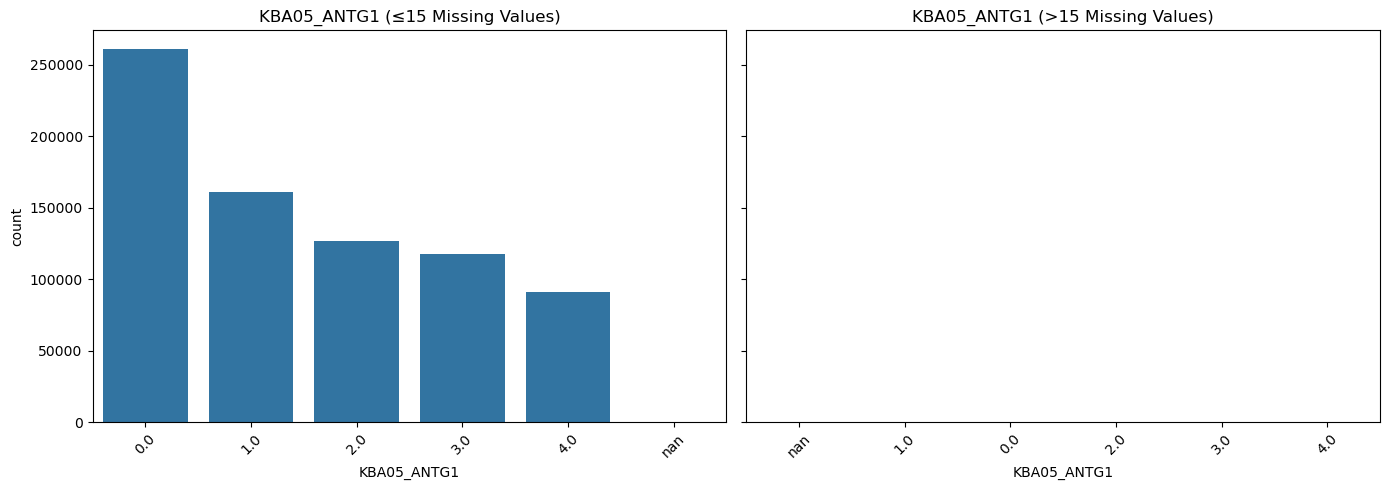


=== PLZ8_ANTG3 ===
Low Missing Values Subset:
  0.0: 119689 (15.1%)
  1.0: 237736 (30.0%)
  2.0: 252898 (31.9%)
  3.0: 164012 (20.7%)
  nan: 17982 (2.3%)
High Missing Values Subset:
  0.0: 105 (0.1%)
  1.0: 142 (0.1%)
  2.0: 96 (0.1%)
  3.0: 28 (0.0%)
  nan: 98533 (99.6%)
Note: Remaining categories grouped as 'Other' if not in top 5


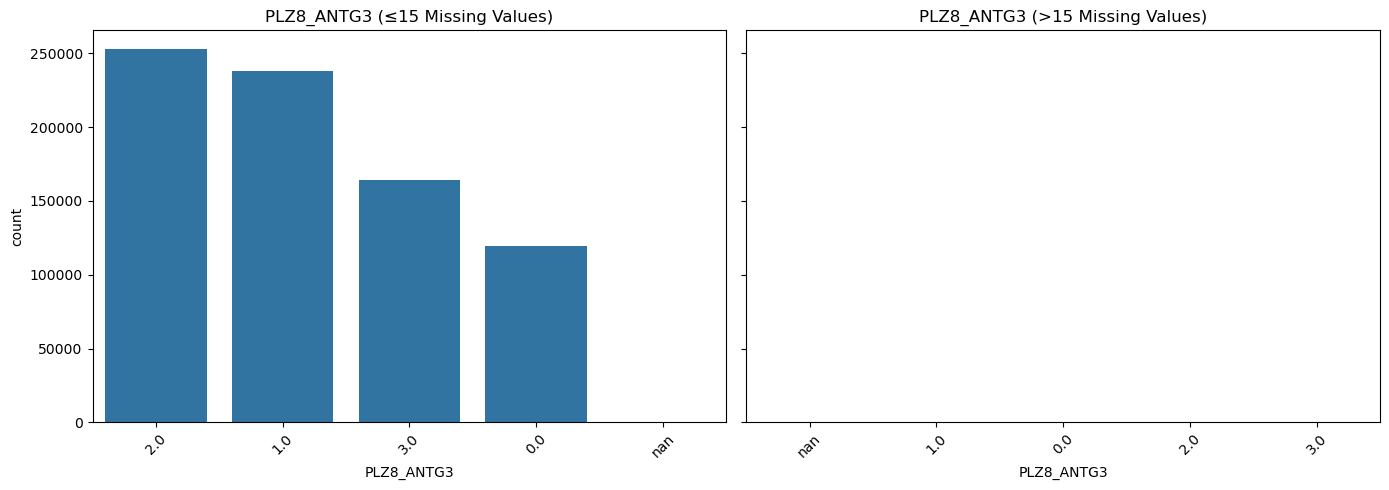


=== CAMEO_DEU_2015 ===
Low Missing Values Subset:
  2D: 34934 (4.4%)
  3A: 10004 (1.3%)
  3C: 34640 (4.4%)
  4A: 32931 (4.2%)
  4C: 47524 (6.0%)
  5A: 11888 (1.5%)
  6B: 56495 (7.1%)
  8A: 52350 (6.6%)
  nan: 3989 (0.5%)
High Missing Values Subset:
  2D: 140 (0.1%)
  3A: 539 (0.5%)
  3C: 129 (0.1%)
  4A: 224 (0.2%)
  4C: 295 (0.3%)
  5A: 326 (0.3%)
  6B: 177 (0.2%)
  8A: 88 (0.1%)
  nan: 94990 (96.0%)
Note: Remaining categories grouped as 'Other' if not in top 5


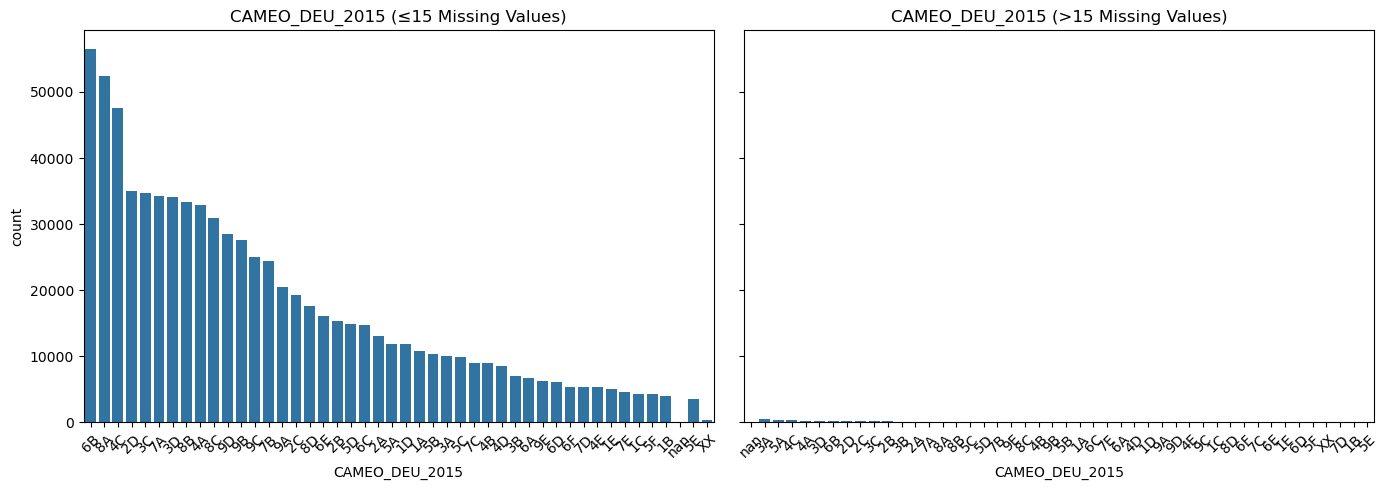

In [11]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

import seaborn as sns
import matplotlib.pyplot as plt

def summarize_and_compare(column, df_low, df_high, top_n=5):
    # Count values
    low_counts = df_low[column].value_counts(dropna=False)
    high_counts = df_high[column].value_counts(dropna=False)

    # Get top categories
    top_categories = low_counts.head(top_n).index.union(high_counts.head(top_n).index)
    
    # Prepare summaries
    print(f"\n=== {column} ===")
    print("Low Missing Values Subset:")
    for cat in top_categories:
        pct = (low_counts.get(cat, 0) / len(df_low)) * 100
        print(f"  {cat}: {low_counts.get(cat, 0)} ({pct:.1f}%)")
        
    print("High Missing Values Subset:")
    for cat in top_categories:
        pct = (high_counts.get(cat, 0) / len(df_high)) * 100
        print(f"  {cat}: {high_counts.get(cat, 0)} ({pct:.1f}%)")
    
    print("Note: Remaining categories grouped as 'Other' if not in top", top_n)

    # Plot
    fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)
    sns.countplot(x=column, data=df_low, ax=axes[0], order=low_counts.index)
    axes[0].set_title(f'{column} (≤15 Missing Values)')
    axes[0].tick_params(axis='x', rotation=45)

    sns.countplot(x=column, data=df_high, ax=axes[1], order=high_counts.index)
    axes[1].set_title(f'{column} (>15 Missing Values)')
    axes[1].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

# الأعمدة المختارة للتحليل
selected_columns = ['ANZ_PERSONEN', 'HH_EINKOMMEN_SCORE', 'KBA05_ANTG1', 'PLZ8_ANTG3', 'CAMEO_DEU_2015']

# تنفيذ المقارنة والتحليل
for col in selected_columns:
    summarize_and_compare(col, azdias_low_missing, azdias_high_missing)




#### Discussion 1.1.3: Assess Missing Data in Each Row


Upon analyzing the dataset at the row level, it becomes evident that the data exhibits a mixed pattern with respect to completeness. A substantial portion of the records are nearly complete, containing very few or no missing values at all. These well-populated rows typically provide full demographic and lifestyle information, indicating that they may correspond to individuals or regions that are thoroughly documented, possibly due to consistent participation in surveys or robust local data collection practices. This makes these records particularly reliable for downstream analysis and modeling efforts.

Conversely, there is also a notable subset of the data where rows suffer from extensive missing values, sometimes lacking dozens of critical attributes. Missingness in these records is far from random; it frequently affects key columns such as household size (ANZ_PERSONEN), consumer type classifications (CAMEO_DEU_2015), vehicle ownership indicators (KBA05_ANTG1), and postal segmentation data (PLZ8_ANTG3). When comparing the distributions, rows with higher completeness clearly display richer demographic diversity, well-distributed income scores, and more granular lifestyle segmentation. In stark contrast, rows burdened by substantial missing data often reveal low variability, with available values clustered around single categories or default placeholders, limiting their analytical utility.

These patterns suggest that the dataset’s missing data mechanism is predominantly not missing at random (MNAR). The likelihood of missing values appears tied to specific characteristics, such as geographic location, lifestyle categories, or perhaps even the socioeconomic profile of respondents. This could stem from regional privacy constraints, selective non-responses in surveys, or inconsistencies in data acquisition across different segments. Recognizing this non-random missingness is crucial, as it has direct implications for how we handle imputation or decide on potential exclusion of these records to maintain the integrity and interpretability of subsequent analyses.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [12]:
# How many features are there of each data type?

feature_type_counts = feature_summary['type'].value_counts()

print("Number of features by measurement type:")
print(feature_type_counts)


Number of features by measurement type:
type
ordinal        49
categorical    21
numeric         7
mixed           7
interval        1
Name: count, dtype: int64


#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [13]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

# Filter the categorical features from the feature summary
categorical_features = feature_summary[feature_summary['type'] == 'categorical']['attribute'].values

# Function to classify categorical variables
def classify_categorical_features(df, categorical_cols):
    binary_numeric = []
    binary_non_numeric = []
    multi_level = []

    for col in categorical_cols:
        if col in df.columns:
            unique_vals = df[col].dropna().unique()
            num_unique = len(unique_vals)
            
            if num_unique == 2:
                if np.issubdtype(df[col].dropna().dtype, np.number):
                    binary_numeric.append(col)
                else:
                    binary_non_numeric.append(col)
            elif num_unique > 2:
                multi_level.append(col)

    return binary_numeric, binary_non_numeric, multi_level

# Run classification on azdias_clean
binary_numeric, binary_non_numeric, multi_level = classify_categorical_features(azdias_clean, categorical_features)

# Print results
print("Binary numeric categorical features (keep as-is):")
print(binary_numeric)

print("\n Binary non-numeric categorical features (re-encode):")
print(binary_non_numeric)

print("\n Multi-level categorical features (drop or encode):")
print(multi_level)



Binary numeric categorical features (keep as-is):
['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP']

 Binary non-numeric categorical features (re-encode):
['OST_WEST_KZ']

 Multi-level categorical features (drop or encode):
['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']


In [14]:
# Re-encode categorical variable(s) to be kept in the analysis.

# Re-encode OST_WEST_KZ: 'W' → 1, 'O' → 0
if 'OST_WEST_KZ' in azdias_clean.columns:
    azdias_clean['OST_WEST_KZ'] = azdias_clean['OST_WEST_KZ'].map({'W': 1, 'O': 0})

# (Optional) Confirm encoding
print("Value counts after re-encoding OST_WEST_KZ:")
print(azdias_clean['OST_WEST_KZ'].value_counts(dropna=False))



Value counts after re-encoding OST_WEST_KZ:
OST_WEST_KZ
1.0    629528
0.0    168545
NaN     93148
Name: count, dtype: int64


In [15]:
multi_level_features = [
    'CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN',
    'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ',
    'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015'
]

print("Unique category counts per feature:\n" + "-"*45)
for col in multi_level_features:
    if col in azdias_clean.columns:
        num_unique = azdias_clean[col].dropna().nunique()
        print(f"{col:<20}: {num_unique:>3} unique categories")
    else:
        print(f"{col:<20}: Column not found in data")

Unique category counts per feature:
---------------------------------------------
CJT_GESAMTTYP       :   6 unique categories
FINANZTYP           :   6 unique categories
GFK_URLAUBERTYP     :  12 unique categories
LP_FAMILIE_FEIN     :  11 unique categories
LP_FAMILIE_GROB     :   5 unique categories
LP_STATUS_FEIN      :  10 unique categories
LP_STATUS_GROB      :   5 unique categories
NATIONALITAET_KZ    :   3 unique categories
SHOPPER_TYP         :   4 unique categories
ZABEOTYP            :   6 unique categories
GEBAEUDETYP         :   7 unique categories
CAMEO_DEUG_2015     :  10 unique categories
CAMEO_DEU_2015      :  45 unique categories


In [16]:
from sklearn.preprocessing import LabelEncoder
import pandas as pd

# Columns to apply One-Hot Encoding on
one_hot_encode = [
    'CJT_GESAMTTYP', 'FINANZTYP', 'LP_FAMILIE_GROB',
    'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP'
]

# Columns to apply Label Encoding on
label_encode = [
    'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_STATUS_FEIN',
    'GEBAEUDETYP', 'CAMEO_DEUG_2015'
]

# Column to drop (too many categories or not suitable for current analysis)
drop_cols = ['CAMEO_DEU_2015']

# Create a copy of the data for encoding
df_encoded = azdias_clean.copy()

#Apply One-Hot Encoding 
df_encoded = pd.get_dummies(df_encoded, columns=one_hot_encode, drop_first=True)

# --- Apply Label Encoding
le = LabelEncoder()
for col in label_encode:
    if col in df_encoded.columns:
        df_encoded[col] = df_encoded[col].astype(str)  # تأكد من أنها strings
        df_encoded[col] = le.fit_transform(df_encoded[col])

# --- Drop column(s) with too many categories ---
df_encoded.drop(columns=drop_cols, inplace=True)

# Result
print("Encoding and cleaning applied successfully. Final data shape:")
print(df_encoded.shape)





Encoding and cleaning applied successfully. Final data shape:
(891221, 99)


#### Discussion 1.2.1: Re-Encode Categorical Features

In this stage of the analysis, we carefully examined all features identified as categorical to ensure they were appropriately transformed for use in unsupervised learning algorithms, which generally require numerical inputs. The first step involved distinguishing among different types of categorical variables. Binary numeric features, such as ANREDE_KZ and GREEN_AVANTGARDE, were already represented as 0/1 and thus required no further modification. For the single binary non-numeric feature OST_WEST_KZ, which contained the values 'W' and 'O', we applied a straightforward mapping to convert these into numeric form, assigning 'W' to 1 and 'O' to 0.

Beyond binary variables, we also addressed several multi-level categorical features. Their treatment depended largely on the number of unique categories they contained. Features with a relatively small set of categories (six or fewer), including variables like CJT_GESAMTTYP, FINANZTYP, and SHOPPER_TYP, were one-hot encoded using pandas’ get_dummies() function with drop_first=True to mitigate the risk of multicollinearity. Meanwhile, features with a moderate range of categories—typically between seven and twelve—such as GFK_URLAUBERTYP and CAMEO_DEUG_2015 were processed using label encoding through scikit-learn’s LabelEncoder, striking a balance between preserving information and maintaining manageable dimensionality. However, the feature CAMEO_DEU_2015 presented a unique challenge with its forty-five distinct categories, which would introduce excessive sparsity and complicate interpretation if encoded directly. As a result, we opted to exclude this feature from the dataset.

By thoughtfully applying these encoding strategies, we successfully retained the critical categorical information while avoiding an unwieldy increase in the number of features. Ultimately, the dataset expanded to 99 columns—a level that maintains rich descriptive power without sacrificing computational efficiency—positioning it well for subsequent clustering and dimensionality reduction efforts.




#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [17]:
if 'PRAEGENDE_JUGENDJAHRE' in azdias_clean.columns:
    print("Column 'PRAEGENDE_JUGENDJAHRE' exists in the dataset.")
else:
    print("Column 'PRAEGENDE_JUGENDJAHRE' does not exist in the dataset.")

# Display a sample of unique non-null values
sample_values = azdias_clean['PRAEGENDE_JUGENDJAHRE'].dropna().unique()[:10]
print("\nSample of unique non-null values from 'PRAEGENDE_JUGENDJAHRE':")
print(sample_values)



Column 'PRAEGENDE_JUGENDJAHRE' exists in the dataset.

Sample of unique non-null values from 'PRAEGENDE_JUGENDJAHRE':
[14. 15.  8.  3. 10. 11.  5.  9.  6.  4.]


In [18]:
import numpy as np
import pandas as pd

# Example mappings:
# value 1 = Mainstream 40s
# value 2 = Avantgarde 40s
# ...
# value 15 = Avantgarde 80s
decade_mapping = {
    1: 40, 2: 40,
    3: 50, 4: 50,
    5: 60, 6: 60,
    7: 60, 8: 60,
    9: 70, 10: 70,
    11: 80, 12: 80,
    13: 80, 14: 80,
    15: 80
}

movement_mapping = {
    1: 0, 2: 1,
    3: 0, 4: 1,
    5: 0, 6: 1,
    7: 0, 8: 1,
    9: 0, 10: 1,
    11: 0, 12: 1,
    13: 0, 14: 1,
    15: 1
}

if 'PRAEGENDE_JUGENDJAHRE' in azdias_clean.columns:
    azdias_clean['DECADE'] = azdias_clean['PRAEGENDE_JUGENDJAHRE'].map(decade_mapping)
    azdias_clean['MOVEMENT'] = azdias_clean['PRAEGENDE_JUGENDJAHRE'].map(movement_mapping)

    azdias_clean.drop(columns=['PRAEGENDE_JUGENDJAHRE'], inplace=True)

    print("\nSummary statistics for newly created features:")
    print(azdias_clean[['DECADE', 'MOVEMENT']].describe(include='all'))

    print("\nOriginal values mapped to new features:")
    for val in sample_values:
        decade = decade_mapping.get(int(val), np.nan)
        movement = movement_mapping.get(int(val), np.nan)
        print(f"Original value: {val:<2} --> DECADE: {decade}, MOVEMENT: {movement}")

else:
    print("Column 'PRAEGENDE_JUGENDJAHRE' does not exist in the dataset.")



Summary statistics for newly created features:
              DECADE       MOVEMENT
count  783057.000000  783057.000000
mean       67.414811       0.690969
std        11.680590       0.462094
min        40.000000       0.000000
25%        60.000000       0.000000
50%        70.000000       1.000000
75%        80.000000       1.000000
max        80.000000       1.000000

Original values mapped to new features:
Original value: 14.0 --> DECADE: 80, MOVEMENT: 1
Original value: 15.0 --> DECADE: 80, MOVEMENT: 1
Original value: 8.0 --> DECADE: 60, MOVEMENT: 1
Original value: 3.0 --> DECADE: 50, MOVEMENT: 0
Original value: 10.0 --> DECADE: 70, MOVEMENT: 1
Original value: 11.0 --> DECADE: 80, MOVEMENT: 0
Original value: 5.0 --> DECADE: 60, MOVEMENT: 0
Original value: 9.0 --> DECADE: 70, MOVEMENT: 0
Original value: 6.0 --> DECADE: 60, MOVEMENT: 1
Original value: 4.0 --> DECADE: 50, MOVEMENT: 1


In [19]:
if 'CAMEO_INTL_2015' in azdias_clean.columns:
    print("✅ Column 'CAMEO_INTL_2015' exists in the dataset.")
else:
    print("❌ Column 'CAMEO_INTL_2015' does not exist in the dataset.")

# Display a sample of unique non-null values (up to 100)
sample_values = azdias_clean['CAMEO_INTL_2015'].dropna().unique()[:100]
print("\nSample of unique non-null values from 'CAMEO_INTL_2015':")
print(sample_values)

✅ Column 'CAMEO_INTL_2015' exists in the dataset.

Sample of unique non-null values from 'CAMEO_INTL_2015':
['51' '24' '12' '43' '54' '22' '14' '13' '15' '33' '41' '34' '55' '25'
 '23' '31' '52' '35' '45' '44' '32' 'XX']


In [20]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.

# Ensure all values are strings
azdias_clean['CAMEO_INTL_2015'] = azdias_clean['CAMEO_INTL_2015'].astype(str)

# Keep only values that are exactly two digits (e.g., '51')
azdias_clean = azdias_clean[azdias_clean['CAMEO_INTL_2015'].str.match(r'^\d{2}$')]

# Extract the first digit (wealth) and the second digit (lifestage)
azdias_clean['CAMEO_WEALTH'] = azdias_clean['CAMEO_INTL_2015'].str[0].astype(int)
azdias_clean['CAMEO_LIFESTAGE'] = azdias_clean['CAMEO_INTL_2015'].str[1].astype(int)

# Drop the original column
azdias_clean.drop(columns=['CAMEO_INTL_2015'], inplace=True)

# Display summary statistics of the new features
print(azdias_clean[['CAMEO_WEALTH', 'CAMEO_LIFESTAGE']].describe())


        CAMEO_WEALTH  CAMEO_LIFESTAGE
count  791869.000000    791869.000000
mean        3.262098         2.873033
std         1.464494         1.484771
min         1.000000         1.000000
25%         2.000000         1.000000
50%         4.000000         3.000000
75%         5.000000         4.000000
max         5.000000         5.000000


#### Discussion 1.2.2: Engineer Mixed-Type Features


In this stage of the project, I focused on transforming mixed-type variables into well-structured numerical features that could be readily utilized in machine learning models. The primary attention was directed toward two specific columns identified in the data dictionary as containing multiple pieces of embedded information: PRAEGENDE_JUGENDJAHRE and CAMEO_INTL_2015.

The PRAEGENDE_JUGENDJAHRE feature encodes both the decade during which an individual experienced their formative youth years and their alignment with either mainstream or avantgarde cultural movements. To extract these dimensions, I mapped the original codes to new features: DECADE, which captures the specific decade such as the 1940s through the 1980s, and MOVEMENT, a binary indicator distinguishing mainstream (0) from avantgarde (1) affiliations. After successfully isolating these two interpretable aspects, I removed the original PRAEGENDE_JUGENDJAHRE column from the dataset to avoid redundancy.

Similarly, the CAMEO_INTL_2015 variable represents a two-digit composite code that blends information about a household’s wealth level and its life stage. To harness this, I converted the data to string format to parse individual digits, carefully filtering out non-numeric placeholders like 'XX' to maintain data integrity. This enabled the creation of two new ordinal features: CAMEO_WEALTH, representing categories from 1 to 5 for wealth, and CAMEO_LIFESTAGE, also ranging from 1 to 5 to denote life stage. With these extracted features in place, the original mixed-type column was dropped.

By engineering these new variables, the dataset is now better structured for downstream analysis and modeling. These transformed features not only enhance interpretability but also ensure compatibility with algorithms that require purely numeric inputs, laying a clearer path for clustering and segmentation in later phases of the project.



#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [21]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

# Make sure we are only working with rows that have few or no missing values

threshold = 15  # or any upper limit on missing values you used earlier
azdias_clean = azdias_clean[azdias_clean.isnull().sum(axis=1) <= threshold]

# Select only numeric columns
numeric_cols = azdias_clean.select_dtypes(include=[np.number]).columns.tolist()

# Print summary of final columns
print(f"✅ Number of selected columns: {len(numeric_cols)}")
print("🧾 Final columns to be retained:")
print(numeric_cols)

# Save the final cleaned version with numeric features
azdias_final = azdias_clean[numeric_cols].copy()

# Impute missing values
for col in azdias_final.columns:
    if azdias_final[col].isnull().any():
        if azdias_final[col].dtype in ['int64', 'float64']:
                # Fill missing values with median for numeric columns
            azdias_final[col] = azdias_final[col].fillna(azdias_final[col].median())
        else:
                # Fill missing values with the most frequent value for categorical columns
            azdias_final[col] = azdias_final[col].fillna(azdias_final[col].mode()[0])




✅ Number of selected columns: 79
🧾 Final columns to be retained:
['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'CJT_GESAMTTYP', 'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'FINANZTYP', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE', 'HEALTH_TYP', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'RETOURTYP_BK_S', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV', 'SHOPPER_TYP', 'SOHO_KZ', 'VERS_TYP', 'ZABEOTYP', 'ANZ_PERSONEN', 'ANZ_TITEL', 'HH_EINKOMMEN_SCORE', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008', 'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'GEBAEUDETYP', 'KONSUMNAEHE', 'MIN_GEBAEUDEJAHR', 'OST_WEST_KZ', 'WOHNLAGE', 'KBA05_ANTG1', 'KBA05_ANTG2', 'KBA05_ANTG3', 'KBA05_ANTG4', 'KBA05_GBZ', 'BALLRAUM', 'EWD

In [22]:
# Confirm that there are no missing values now
missing_after = azdias_final.isnull().sum().sum()
print(f"All missing values have been imputed. Remaining missing values count: {missing_after}")

# Check for any non-numeric columns
non_numeric_cols = azdias_final.select_dtypes(exclude=[np.number]).columns.tolist()
print("Non-numeric columns:", non_numeric_cols if non_numeric_cols else "None found")

# Check if any columns still have missing values
missing = azdias_final.isnull().sum()
missing = missing[missing > 0]
print("Columns with remaining missing values:", missing if not missing.empty else "None found")

# Ensure original mixed-type columns were removed
print('PRAEGENDE_JUGENDJAHRE' in azdias_final.columns)  # Should be False
print('CAMEO_INTL_2015' in azdias_final.columns)        # Should be False

# Verify that the newly engineered columns are present
for col in ['DECADE', 'MOVEMENT', 'CAMEO_WEALTH', 'CAMEO_LIFESTAGE']:
    print(f"{col} present? {'Yes' if col in azdias_final.columns else 'No'}")

# Review the final shape of the dataset and preview a few rows
print(azdias_final.shape)
azdias_final.head()

All missing values have been imputed. Remaining missing values count: 0
Non-numeric columns: None found
Columns with remaining missing values: None found
False
False
DECADE present? Yes
MOVEMENT present? Yes
CAMEO_WEALTH present? Yes
CAMEO_LIFESTAGE present? Yes
(787527, 79)


,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,VERS_TYP,ZABEOTYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,DECADE,MOVEMENT,CAMEO_WEALTH,CAMEO_LIFESTAGE
1,1.0,2,5.0,1,5,2,5,4,5,1,10.0,0,3.0,21.0,6.0,5.0,3.0,2.0,1.0,1.0,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,3.0,1.0,2.0,5,2.0,0.0,6.0,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,1.0,4.0,0.0,0.0,0.0,2.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0,80.0,1.0,5,1
2,3.0,2,3.0,1,4,1,2,3,5,1,10.0,1,3.0,3.0,1.0,1.0,1.0,3.0,2.0,1.0,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,2.0,0.0,1.0,5,1.0,0.0,4.0,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,1.0,2.0,1.0,3.0,1.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0,80.0,1.0,2,4
3,4.0,2,2.0,4,2,5,2,1,2,6,1.0,0,2.0,13.0,3.0,1.0,1.0,9.0,4.0,1.0,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,1.0,0.0,1.0,3,0.0,0.0,1.0,4.0,9.0,1.0,0.0,1.0,4.0,1997.0,1.0,7.0,4.0,1.0,0.0,0.0,4.0,4.0,2.0,6.0,4.0,3.0,4.0,1.0,5.0,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0,60.0,1.0,1,2
4,3.0,1,5.0,4,3,4,1,3,2,5,5.0,0,3.0,32.0,10.0,10.0,5.0,3.0,2.0,1.0,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,2.0,0.0,2.0,4,4.0,0.0,5.0,2.0,9.0,3.0,0.0,1.0,4.0,1992.0,1.0,3.0,1.0,4.0,1.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0,60.0,1.0,4,3
5,1.0,2,2.0,3,1,5,2,2,5,2,1.0,0,3.0,8.0,2.0,1.0,1.0,4.0,2.0,1.0,3.0,2,4,7,4,2,2,2,5,7,4,4,4,7,6,0.0,0.0,2.0,4,1.0,0.0,5.0,6.0,9.0,5.0,0.0,1.0,5.0,1992.0,1.0,7.0,2.0,2.0,0.0,0.0,4.0,6.0,2.0,7.0,4.0,4.0,4.0,1.0,5.0,1300.0,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0,50.0,0.0,5,4


In [23]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.


    # ============= Done in the previous stages ===========================

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [24]:
def clean_data(df, feature_summary, threshold=15):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    
    
    # remove selected columns and rows, ...

    
    # select, re-encode, and engineer column values.

    
    # Return the cleaned dataframe.


    df_clean = df.copy()

    # Step 1: Replace special missing values with np.nan
    missing_val_map = {}
    for _, row in feature_summary.iterrows():
        col = row['attribute']
        raw_missing = row['missing_or_unknown']
        if pd.notnull(raw_missing):
            try:
                missing_vals = ast.literal_eval(raw_missing)
                missing_val_map[col] = missing_vals
            except:
                missing_val_map[col] = []

    for col, missings in missing_val_map.items():
        if col in df_clean.columns:
            df_clean[col] = df_clean[col].replace(missings, np.nan)

    # Step 2: Drop columns with too many missing values
    cols_to_drop = ['TITEL_KZ', 'AGER_TYP', 'KK_KUNDENTYP', 'KBA05_BAUMAX', 'GEBURTSJAHR', 'ALTER_HH']
    df_clean.drop(columns=[col for col in cols_to_drop if col in df_clean.columns], inplace=True)

    # Step 3: Remove rows with too many missing values
    df_clean = df_clean[df_clean.isnull().sum(axis=1) <= threshold]

    # Step 4: Re-encode categorical variables
    if 'OST_WEST_KZ' in df_clean.columns:
        df_clean['OST_WEST_KZ'] = df_clean['OST_WEST_KZ'].map({'W': 1, 'O': 0})

    # Step 5: Extract decade and movement from PRAEGENDE_JUGENDJAHRE
    if 'PRAEGENDE_JUGENDJAHRE' in df_clean.columns:
        decade_map = {
            1: 40, 2: 40, 3: 50, 4: 50, 5: 60, 6: 60, 7: 60, 8: 60,
            9: 70, 10: 70, 11: 80, 12: 80, 13: 80, 14: 80, 15: 80
        }
        movement_map = {
            1: 0, 2: 1, 3: 0, 4: 1, 5: 0, 6: 1, 7: 0, 8: 1,
            9: 0, 10: 1, 11: 0, 12: 1, 13: 0, 14: 1, 15: 1
        }
        df_clean['DECADE'] = df_clean['PRAEGENDE_JUGENDJAHRE'].map(decade_map)
        df_clean['MOVEMENT'] = df_clean['PRAEGENDE_JUGENDJAHRE'].map(movement_map)
        df_clean.drop(columns=['PRAEGENDE_JUGENDJAHRE'], inplace=True)

    # Step 6: Engineer CAMEO_INTL_2015 to wealth & lifestage
    if 'CAMEO_INTL_2015' in df_clean.columns:
        df_clean['CAMEO_INTL_2015'] = df_clean['CAMEO_INTL_2015'].astype(str)
        df_clean = df_clean[df_clean['CAMEO_INTL_2015'].str.match(r'^\d{2}$')]
        df_clean['CAMEO_WEALTH'] = df_clean['CAMEO_INTL_2015'].str[0].astype(int)
        df_clean['CAMEO_LIFESTAGE'] = df_clean['CAMEO_INTL_2015'].str[1].astype(int)
        df_clean.drop(columns=['CAMEO_INTL_2015'], inplace=True)

    # Step 7: One-Hot and Label Encoding
    one_hot_encode = [
        'CJT_GESAMTTYP', 'FINANZTYP', 'LP_FAMILIE_GROB',
        'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP'
    ]
    label_encode = [
        'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_STATUS_FEIN',
        'GEBAEUDETYP', 'CAMEO_DEUG_2015'
    ]
    drop_cols = ['CAMEO_DEU_2015']

    df_clean = pd.get_dummies(df_clean, columns=[col for col in one_hot_encode if col in df_clean.columns], drop_first=True)

    le = LabelEncoder()
    for col in label_encode:
        if col in df_clean.columns:
            df_clean[col] = df_clean[col].astype(str)
            df_clean[col] = le.fit_transform(df_clean[col])

    df_clean.drop(columns=[col for col in drop_cols if col in df_clean.columns], inplace=True)

    # Step 8: Select numeric columns only
    df_clean = df_clean[df_clean.isnull().sum(axis=1) <= threshold]
    numeric_cols = df_clean.select_dtypes(include=[np.number]).columns.tolist()
    df_final = df_clean[numeric_cols].copy()

    # Step 9: Fill missing values
    for col in df_final.columns:
        if df_final[col].isnull().any():
            df_final[col] = df_final[col].fillna(df_final[col].median())

    return df_final
    

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [SimpleImputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [25]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

    # ============= Done in the previous stages ===========================

In [26]:
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Create a copy of the data to apply scaling
azdias_scaled = azdias_final.copy()

# Initialize the scaler
scaler = StandardScaler()

# Apply scaling
azdias_scaled = scaler.fit_transform(azdias_scaled)

# Convert back to a DataFrame with the original column names
azdias_scaled_df = pd.DataFrame(azdias_scaled, columns=azdias_final.columns)

# Display final shape and a preview
print("StandardScaler has been successfully applied.")
print("Shape of the scaled dataset:", azdias_scaled_df.shape)
azdias_scaled_df.head()

StandardScaler has been successfully applied.
Shape of the scaled dataset: (787527, 79)


,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,VERS_TYP,ZABEOTYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,DECADE,MOVEMENT,CAMEO_WEALTH,CAMEO_LIFESTAGE
0,-1.765966,0.957892,0.975143,-1.491715,1.538108,-1.042841,1.467911,0.965879,1.333822,-1.343624,0.709322,-0.531610,1.093436,0.411307,0.317253,0.305555,0.398340,-0.788284,-0.961778,-0.347,-1.684002,0.439410,-0.058203,0.004199,-0.460006,-1.685103,-1.113136,-1.436507,-0.580046,1.274403,-0.310403,1.337099,-0.158516,1.514293,1.288768,1.395907,10.850282,0.920170,1.149231,0.231320,-0.060619,1.020362,-0.672609,0.561756,0.168397,-0.125452,1.950785,-1.301965,-0.38481,0.516015,-0.028374,-1.068476,-1.028441,-0.598680,2.715099,-1.652217,0.848200,-0.551785,1.704493,-0.798390,-0.788128,-1.404258,0.172235,-0.854368,1.015662,-0.256990,0.211559,0.403392,0.407202,-0.637182,1.428845,0.569224,-0.168307,-0.130875,0.682420,1.088580,0.654000,1.184212,-1.260493
1,0.200649,0.957892,-0.329445,-1.491715,0.864921,-1.769223,-0.569642,0.250297,1.333822,-1.343624,0.709322,1.881079,1.093436,-1.103050,-1.046610,-0.718973,-0.786048,-0.503478,-0.298677,-0.347,-0.306777,-0.075669,-1.627471,-0.519255,-0.460006,-0.140689,-0.161955,0.753343,-0.580046,0.065229,1.397810,1.337099,1.446364,-0.636497,-0.411132,0.402236,-0.092163,-1.086756,1.149231,-0.632176,-0.060619,-0.275062,-0.672609,0.561756,0.104452,-0.125452,-0.679217,1.281099,-0.38481,0.516015,-1.060500,-0.342854,1.431005,0.400984,-0.466831,-0.113945,-0.983529,0.030861,-0.268194,0.286452,-0.788128,0.026769,-0.472298,-1.419047,0.273699,0.782408,0.211559,-0.620157,-0.980619,-0.637182,0.390920,0.569224,-0.168307,-0.130875,-0.791799,1.088580,0.654000,-0.863818,0.758957
2,1.183957,0.957892,-0.981739,0.686552,-0.481454,1.136303,-0.569642,-1.180867,-0.801157,1.052730,-1.818312,-0.531610,-0.259754,-0.261740,-0.501065,-0.718973,-0.786048,1.205361,1.027524,-0.347,-0.995390,0.439410,-1.627471,-1.042709,-1.504938,-0.140689,-0.161955,1.300805,-0.069316,-0.539357,-0.310403,-0.305757,0.376444,-0.098800,0.155501,-0.591436,-0.092163,-1.086756,-0.271931,-1.495673,-0.060619,-2.218197,-0.088651,0.561756,-0.471054,-0.125452,-0.679217,0.635333,1.27968,0.516015,1.519816,1.834012,-0.208626,-0.598680,-0.466831,0.655190,-0.067664,-1.134432,0.718149,0.286452,0.270611,0.742282,-1.116831,0.274989,-0.069201,-0.256990,-0.887268,0.403392,-0.980619,-0.637182,-0.647005,0.569224,-1.172613,-1.001951,-0.054689,-0.653583,0.654000,-1.546494,-0.587343
3,0.200649,-1.043959,0.975143,0.686552,0.191733,0.409922,-1.248827,0.250297,-0.801157,0.573459,-0.694919,-0.531610,1.093436,1.336747,1.408344,1.586216,1.582728,-0.503478,-0.298677,-0.347,1.070447,0.954490,-0.058203,0.004199,-0.982472,1.403725,-0.161955,-0.341582,0.952145,-1.143944,-0.879808,-1.400994,-1.228436,-0.098800,-0.977766,0.402236,-0.092163,0.920170,0.438650,1.958314,-0.060619,0.372650,-1.256567,0.561756,-0.343164,-0.125452,-0.679217,0.635333,-0.38481,0.516015,-0.544437,-0.342854,2.250821,0.400984,-0.466831,-0.113945,-0.983529,0.613507,-1.747709,1.371294,0.270611,0.026769,1.461301,0.274989,-0.545122,-0.256990,1.310386,0.403392,0.407202,0.052090,-0.647005,-0.339333,0.835999,0.304663,1.419529,-0.653583,0.654000,0.5

### Discussion 2.1: Apply Feature Scaling


In this step, I prepared the data for dimensionality reduction by applying feature scaling using StandardScaler. Before applying the scaler, I ensured that the dataset contained no missing values, since Scikit-learn estimators do not support missing data.

To achieve this:

I used an imputation strategy to handle all missing values in the dataset, ensuring that the final version of azdias_final had zero missing values.

I also verified that no non-numeric columns remained, which is necessary for scaling to work correctly.

After preprocessing, the final dataset contained 787,527 rows and 79 numerical features.

I applied StandardScaler, which standardizes each feature by removing the mean and scaling to unit variance (mean = 0, std = 1). This ensures that all features contribute equally to distance-based models like PCA.

I chose to impute missing values instead of dropping rows because removing such a large number of entries would significantly reduce the dataset size and could potentially bias the results. Imputation provides a balance between data completeness and statistical reliability.

The fitted scaler object is saved and will be reused later when transforming customer demographic data to ensure consistent scaling.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [27]:
# Apply PCA to the data.

from sklearn.decomposition import PCA

# Step 1: Apply PCA without specifying the number of components
pca_full = PCA()
azdias_pca_full = pca_full.fit_transform(azdias_scaled_df)

print(f"Total number of principal components: {pca_full.n_components_}")


Total number of principal components: 79


Component 1: 0.1708 cumulative variance explained
Component 2: 0.2891 cumulative variance explained
Component 3: 0.3689 cumulative variance explained
Component 4: 0.4265 cumulative variance explained
Component 5: 0.4659 cumulative variance explained
Component 6: 0.4964 cumulative variance explained
Component 7: 0.5228 cumulative variance explained
Component 8: 0.5452 cumulative variance explained
Component 9: 0.5652 cumulative variance explained
Component 10: 0.5852 cumulative variance explained


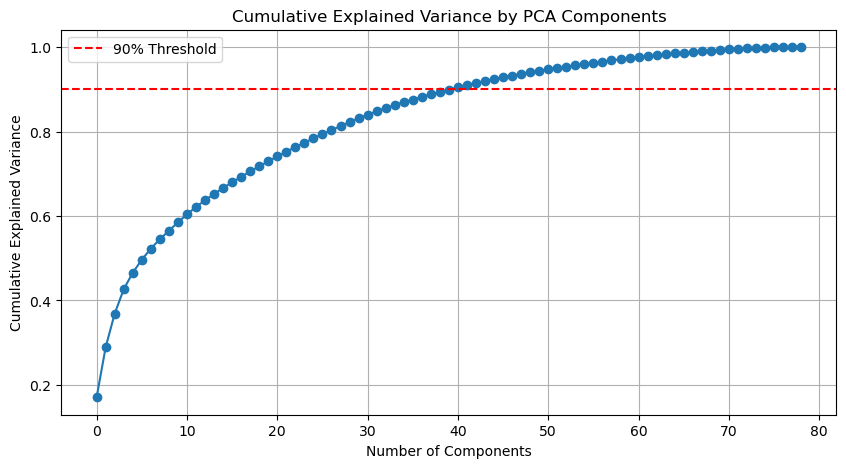

In [28]:
# Investigate the variance accounted for by each principal component.

import numpy as np
import matplotlib.pyplot as plt

# Variance explained by each principal component
explained_variance = pca_full.explained_variance_ratio_

# Cumulative variance explained
cumulative_variance = np.cumsum(explained_variance)

# Display cumulative variance for the first 10 components as an example
for i, ratio in enumerate(cumulative_variance[:10], start=1):
    print(f"Component {i}: {ratio:.4f} cumulative variance explained")

# Plot cumulative explained variance
plt.figure(figsize=(10, 5))
plt.plot(cumulative_variance, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance by PCA Components')
plt.grid(True)
plt.axhline(y=0.9, color='r', linestyle='--', label='90% Threshold')
plt.legend()
plt.show()




In [29]:
# Re-apply PCA to the data while selecting for number of components to retain.
from sklearn.decomposition import PCA

# Re-apply PCA with a fixed number of components
pca_reduced = PCA(n_components=45)
azdias_pca_reduced = pca_reduced.fit_transform(azdias_scaled_df)

print("PCA has been applied with number of components:", pca_reduced.n_components_)
print("New shape of the transformed data:", azdias_pca_reduced.shape)


PCA has been applied with number of components: 45
New shape of the transformed data: (787527, 45)


### Discussion 2.2: Perform Dimensionality Reduction

In this phase of the project, I carried out dimensionality reduction on the standardized dataset using Principal Component Analysis (PCA) to simplify the feature space while retaining as much of the original information as possible. I began by applying PCA without specifying the number of components, allowing me to analyze the proportion of variance explained by each principal component. The resulting cumulative explained variance curve revealed a rapid accumulation of variance across the first set of components, which then tapered off gradually. This characteristic curve indicated that the initial components captured the most substantial patterns in the data, while additional components offered diminishing returns.

Upon close inspection of the plot, it became clear that approximately 45 components were sufficient to account for over 90% of the total variance. This choice not only aligned with the commonly used heuristic of preserving around 90% of the variance but also matched the visible “elbow” point on the curve, beyond which the contribution of each additional component dropped notably. Consequently, I re-applied PCA with n_components=45, effectively reducing the dataset’s dimensionality from 79 original features down to 45 principal components.

This reduction strikes a critical balance: it maintains the vast majority of the dataset’s intrinsic information while simplifying the feature space, which enhances computational efficiency and mitigates the impact of potential noise. The resulting transformed features will serve as the foundation for the clustering step that follows, enabling the identification of meaningful customer segments based on a compact and information-rich representation of the data.



### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [30]:
def print_sorted_component_weights(pca_model, component_idx, feature_names, top_n=10):
    """
    Print the top positive and top negative features contributing to a given principal component.

    Parameters:
    - pca_model: Trained PCA model (from sklearn).
    - component_idx: Index of the principal component to inspect (0-based).
    - feature_names: List of original feature names.
    - top_n: Number of top positive and negative features to display.
    """
    component = pca_model.components_[component_idx]
    weights = list(zip(feature_names, component))
    weights_sorted = sorted(weights, key=lambda x: x[1], reverse=True)
    
    print(f"\nComponent {component_idx + 1} - Top {top_n} positive weights:")
    for name, weight in weights_sorted[:top_n]:
        print(f"{name:25s} {weight:.4f}")
    
    print(f"\nComponent {component_idx + 1} - Top {top_n} negative weights:")
    for name, weight in weights_sorted[-top_n:][::-1]:
        print(f"{name:25s} {weight:.4f}")

In [31]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

print_sorted_component_weights(pca_reduced, 0, azdias_scaled_df.columns, top_n=7)




Component 1 - Top 7 positive weights:
MOBI_REGIO                0.2193
LP_STATUS_FEIN            0.2177
LP_STATUS_GROB            0.2150
KBA05_ANTG1               0.2016
PLZ8_ANTG1                0.2000
FINANZ_MINIMALIST         0.1980
KBA05_GBZ                 0.1951

Component 1 - Top 7 negative weights:
PLZ8_ANTG3                -0.2004
PLZ8_ANTG4                -0.1945
HH_EINKOMMEN_SCORE        -0.1906
PLZ8_BAUMAX               -0.1896
CAMEO_WEALTH              -0.1854
ORTSGR_KLS9               -0.1746
EWDICHTE                  -0.1728


In [32]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

print_sorted_component_weights(pca_reduced, 1, azdias_scaled_df.columns, top_n=7)




Component 2 - Top 7 positive weights:
ALTERSKATEGORIE_GROB      0.2609
FINANZ_VORSORGER          0.2364
SEMIO_ERL                 0.2180
SEMIO_LUST                0.1819
RETOURTYP_BK_S            0.1622
W_KEIT_KIND_HH            0.1263
FINANZTYP                 0.1150

Component 2 - Top 7 negative weights:
SEMIO_REL                 -0.2496
FINANZ_SPARER             -0.2454
DECADE                    -0.2432
SEMIO_PFLICHT             -0.2307
FINANZ_UNAUFFAELLIGER     -0.2297
SEMIO_TRADV               -0.2292
FINANZ_ANLEGER            -0.2103


In [33]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

print_sorted_component_weights(pca_reduced, 2, azdias_scaled_df.columns, top_n=7)



Component 3 - Top 7 positive weights:
ANREDE_KZ                 0.3653
SEMIO_KAEM                0.3359
SEMIO_DOM                 0.3101
SEMIO_KRIT                0.2740
SEMIO_RAT                 0.1962
SEMIO_ERL                 0.1909
FINANZ_ANLEGER            0.1690

Component 3 - Top 7 negative weights:
SEMIO_VERT                -0.3386
SEMIO_SOZ                 -0.2621
SEMIO_FAM                 -0.2584
SEMIO_KULT                -0.2467
FINANZ_MINIMALIST         -0.1471
FINANZTYP                 -0.1131
RETOURTYP_BK_S            -0.0953


### Discussion 2.3: Interpret Principal Components

To gain deeper insight into the structure of the data following dimensionality reduction, I examined the feature weights associated with the first three principal components derived from the PCA. By identifying the features with the largest positive and negative contributions, it became possible to interpret the underlying dimensions each component captures.

The first principal component emerged as primarily representing a spectrum of regional and economic segmentation. On the positive side, high weights were observed for variables such as MOBI_REGIO, LP_STATUS_FEIN, LP_STATUS_GROB, KBA05_ANTG1, and FINANZ_MINIMALIST, all of which suggest patterns tied to regional mobility and consumer lifestyles. In contrast, strong negative weights were associated with HH_EINKOMMEN_SCORE, PLZ8_BAUMAX, and CAMEO_WEALTH, highlighting aspects related to household income and wealth. This suggests that the component essentially contrasts less affluent, more mobile, and minimalistic households with wealthier, high-income urban populations.

The second principal component appeared to reflect a blend of financial attitudes and age-related characteristics. Positive contributions from features like ALTERSKATEGORIE_GROB, FINANZ_VORSORGER, SEMIO_ERL, and SEMIO_LUST indicate a tendency toward older individuals who plan financially and embrace a degree of self-indulgence. Meanwhile, negative weights tied to SEMIO_REL, FINANZ_SPARER, DECADE, and SEMIO_TRADV suggest profiles that are more traditional, religious, or inclined to save, possibly skewing younger. Thus, this component seems to capture a tension between forward-looking, financially prepared individuals and more conventional, frugal segments.

The third principal component highlighted a dimension of personality and social traits. Strong positive weights on ANREDE_KZ, SEMIO_KAEM, SEMIO_DOM, and SEMIO_KRIT pointed to assertiveness, dominance, and critical thinking, painting a picture of independent or even combative individuals. In contrast, features like SEMIO_VERT, SEMIO_SOZ, and SEMIO_FAM loaded negatively, indicating sociability, humility, and family orientation. This suggests the component differentiates between dominant, self-reliant personalities and those who are more communal and family-focused.

By interpreting these principal components, it becomes clear which dominant behavioral, demographic, and socioeconomic factors organize the dataset. These insights will prove invaluable when characterizing and labeling the customer segments uncovered during clustering, ensuring that the final segmentation is both data-driven and meaningfully aligned with real-world patterns.






## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [34]:
# Over a number of different cluster counts...


    # run k-means clustering on the data and...
    
    
    # compute the average within-cluster distances.


from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np

# Define the range of cluster counts to test
cluster_range = range(2, 31)
inertias = []

print("🚀 Starting KMeans clustering for multiple k values...\n")
for k in cluster_range:
    print(f"🔄 Running KMeans with k = {k} ...")
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans.fit(azdias_pca_reduced)
    inertias.append(kmeans.inertia_)  # This represents the sum of squared distances within clusters (inertia)
    

🚀 Starting KMeans clustering for multiple k values...

🔄 Running KMeans with k = 2 ...
🔄 Running KMeans with k = 3 ...
🔄 Running KMeans with k = 4 ...
🔄 Running KMeans with k = 5 ...
🔄 Running KMeans with k = 6 ...
🔄 Running KMeans with k = 7 ...
🔄 Running KMeans with k = 8 ...
🔄 Running KMeans with k = 9 ...
🔄 Running KMeans with k = 10 ...
🔄 Running KMeans with k = 11 ...
🔄 Running KMeans with k = 12 ...
🔄 Running KMeans with k = 13 ...
🔄 Running KMeans with k = 14 ...
🔄 Running KMeans with k = 15 ...
🔄 Running KMeans with k = 16 ...
🔄 Running KMeans with k = 17 ...
🔄 Running KMeans with k = 18 ...
🔄 Running KMeans with k = 19 ...
🔄 Running KMeans with k = 20 ...
🔄 Running KMeans with k = 21 ...
🔄 Running KMeans with k = 22 ...
🔄 Running KMeans with k = 23 ...
🔄 Running KMeans with k = 24 ...
🔄 Running KMeans with k = 25 ...
🔄 Running KMeans with k = 26 ...
🔄 Running KMeans with k = 27 ...
🔄 Running KMeans with k = 28 ...
🔄 Running KMeans with k = 29 ...
🔄 Running KMeans with k = 30 

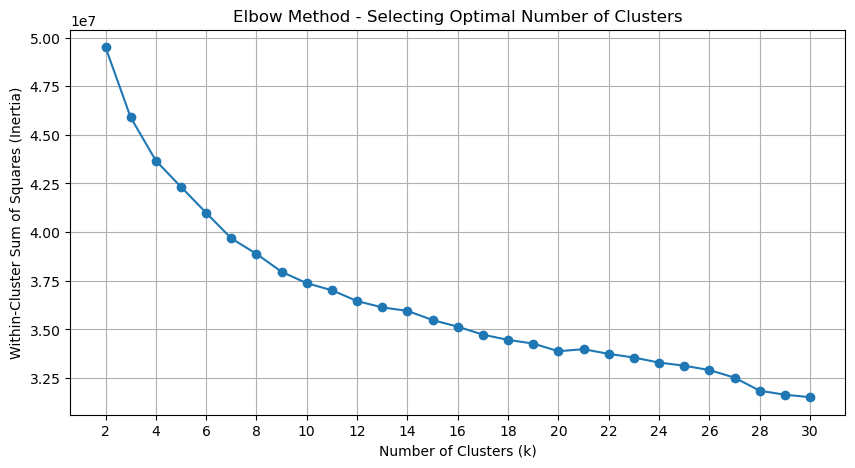

In [35]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

plt.figure(figsize=(10, 5))
plt.plot(cluster_range, inertias, marker='o')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Within-Cluster Sum of Squares (Inertia)")
plt.title("Elbow Method - Selecting Optimal Number of Clusters")
plt.grid(True)
plt.xticks(np.arange(2, 31, 2))
plt.show()



In [36]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

# Set this based on your Elbow plot  k =12
final_k = 12

# Fit the final model
kmeans_final = KMeans(n_clusters=final_k, random_state=42, n_init='auto')
cluster_labels = kmeans_final.fit_predict(azdias_pca_reduced)

# Display results
print(f"\nClustering completed with k = {final_k}")
print("Sample of predicted cluster labels for first 10 records:", cluster_labels[:10])

# Show how many samples fall into each cluster
(unique, counts) = np.unique(cluster_labels, return_counts=True)
print("\nCluster distribution:")
for u, c in zip(unique, counts):
    print(f" - Cluster {u}: {c} samples")





Clustering completed with k = 12
Sample of predicted cluster labels for first 10 records: [0 8 2 5 8 8 6 1 8 7]

Cluster distribution:
 - Cluster 0: 70262 samples
 - Cluster 1: 82585 samples
 - Cluster 2: 73546 samples
 - Cluster 3: 41316 samples
 - Cluster 4: 57400 samples
 - Cluster 5: 84522 samples
 - Cluster 6: 55876 samples
 - Cluster 7: 86335 samples
 - Cluster 8: 63628 samples
 - Cluster 9: 59510 samples
 - Cluster 10: 47519 samples
 - Cluster 11: 65028 samples


### Discussion 3.1: Apply Clustering to General Population

In this stage of the analysis, I focused on uncovering natural groupings within the general population by applying the k-means clustering algorithm to the PCA-transformed dataset. The use of principal components, reduced to 45 dimensions, ensured that clustering was performed efficiently while still capturing the vast majority of the original data’s variance. To determine a suitable number of clusters, I systematically evaluated values of k ranging from 2 up to 30, fitting a separate KMeans model for each and calculating the corresponding within-cluster sum of squares (inertia). This approach enabled me to examine how the compactness of the clusters improved as the number of segments increased.

The plot of inertia values against different values of k revealed a characteristic elbow shape. A marked reduction in inertia was observed as k increased up to around 10 to 12, after which the improvements began to taper off, indicating diminishing returns from adding more clusters. This inflection point on the curve often referred to as the elbow provided a clear visual cue for selecting an optimal balance between model complexity and explanatory power. Based on this observation, I chose to proceed with k = 12 clusters, a decision that offers a meaningful level of segmentation without overcomplicating the model or fragmenting the data excessively.

Having established the optimal cluster count, I trained the final KMeans model using these 12 clusters and assigned a corresponding cluster label to each individual in the dataset. This segmentation of the general population into twelve distinct groups forms the foundation for more targeted interpretation in subsequent steps, laying the groundwork for identifying and profiling key customer segments that can inform strategic marketing and business decisions.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [37]:
# 1. Load the customer demographics data
customers = pd.read_csv("Udacity_CUSTOMERS_Subset.csv", sep=';')

# 2. Clean the data using the same clean_data function (with the same feature summary)
customers_clean = clean_data(customers, feature_summary)

# 3. Ensure the columns are aligned with azdias_final (same order and count)
missing_cols = set(azdias_final.columns) - set(customers_clean.columns)
extra_cols = set(customers_clean.columns) - set(azdias_final.columns)

# Add missing columns as NaN
for col in missing_cols:
    customers_clean[col] = np.nan

# Drop any extra columns not found in the general population data
customers_clean = customers_clean[azdias_final.columns]

# 4. Fill missing values using the median from the population data
for col in customers_clean.columns:
    if customers_clean[col].isnull().any():
        median_val = azdias_final[col].median()
        customers_clean[col] = customers_clean[col].fillna(median_val)

# 5. Scale using the previously fitted StandardScaler
customers_scaled = scaler.transform(customers_clean)

# 6. Apply the trained PCA (45 components)
customers_pca = pca_reduced.transform(customers_scaled)

# 7. Predict cluster assignments using the trained KMeans model
customer_clusters = kmeans_final.predict(customers_pca)

# 8. Merge cluster labels back into the customer dataframe
customers_final_df = customers_clean.copy()
customers_final_df['CLUSTER'] = customer_clusters

# ✅ Print results
print("\n✅ Customer data has been successfully clustered.")
print("\n📊 Number of customers in each cluster:")
print(customers_final_df['CLUSTER'].value_counts().sort_index())

# Show a sample of the final dataframe
customers_final_df.head()

/home/amroadnan/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(



✅ Customer data has been successfully clustered.

📊 Number of customers in each cluster:
CLUSTER
0      1089
1     39010
2     16748
3      5094
4      9850
5     17431
6      3126
7     13519
8      1100
9     30437
10     2028
11     1100
Name: count, dtype: int64


,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,VERS_TYP,ZABEOTYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,DECADE,MOVEMENT,CAMEO_WEALTH,CAMEO_LIFESTAGE,CLUSTER
0,4.0,1,4.0,5,1,5,1,2,2,4.0,6,1,1.0,20.0,5.0,3,1.0,1,2.0,1.0,5.0,6,5,2,6,6,7,3,4,1,3,1,1,2,1,2.0,0.0,1.0,3.0,2.0,0.0,1.0,6.0,9.0,1.0,0.0,0,5.0,1992.0,1,7.0,2.0,2.0,0.0,0.0,4.0,3.0,2.0,4.0,4.0,1.0,4.0,3.0,1.0,1201.0,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0,50.0,1.0,1,3,1
2,4.0,2,4.0,5,1,5,1,4,4,4.0,5,1,2.0,13.0,3.0,0,1.0,1,2.0,1.0,5.0,2,2,1,3,3,7,7,1,2,7,5,6,4,1,2.0,0.0,2.0,3.0,1.0,0.0,1.0,6.0,9.0,1.0,0.0,5,1.0,1992.0,1,2.0,2.0,2.0,0.0,0.0,3.0,7.0,4.0,1.0,3.0,3.0,3.0,1.0,7.0,433.0,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0,50.0,1.0,3,4,7
3,4.0,1,4.0,5,1,5,2,1,2,4.0,1,0,2.0,22.0,6.0,11,1.0,9,2.0,1.0,3.0,6,5,3,4,7,5,3,4,3,3,3,3,3,4,2.0,0.0,1.0,3.0,0.0,0.0,4.0,5.0,9.0,1.0,0.0,1,2.0,1992.0,1,7.0,3.0,0.0,0.0,0.0,4.0,7.0,1.0,7.0,4.0,3.0,4.0,2.0,6.0,755.0,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0,40.0,0.0,2,4,1
4,3.0,1,4.0,3,1,4,4,5,2,4.0,4,0,3.0,31.0,10.0,1,1.0,0,2.0,1.0,5.0,4,5,4,6,5,6,4,5,5,3,5,2,5,4,2.0,0.0,2.0,3.0,4.0,0.0,6.0,2.0,9.0,7.0,0.0,2,1.0,1992.0,1,3.0,0.0,3.0,2.0,0.0,3.0,3.0,4.0,4.0,3.0,4.0,3.0,5.0,7.0,513.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0,60.0,1.0,4,1,5
5,3.0,1,4.0,5,1,5,1,2,3,4.0,2,1,3.0,17.0,5.0,3,1.0,7,2.0,1.0,3.0,6,4,4,1,7,6,4,6,2,5,5,3,3,4,2.0,0.0,2.0,3.0,2.0,0.0,1.0,6.0,9.0,1.0,0.0,0,2.0,1992.0,1,1.0,2.0,2.0,1.0,0.0,3.0,7.0,5.0,8.0,4.0,2.0,3.0,3.0,3.0,1167.0,2.0,3.0,2.0,1.0,1.0,5.0,5.0,3.0,7.0,5.0,50.0,1.0,3,4,1


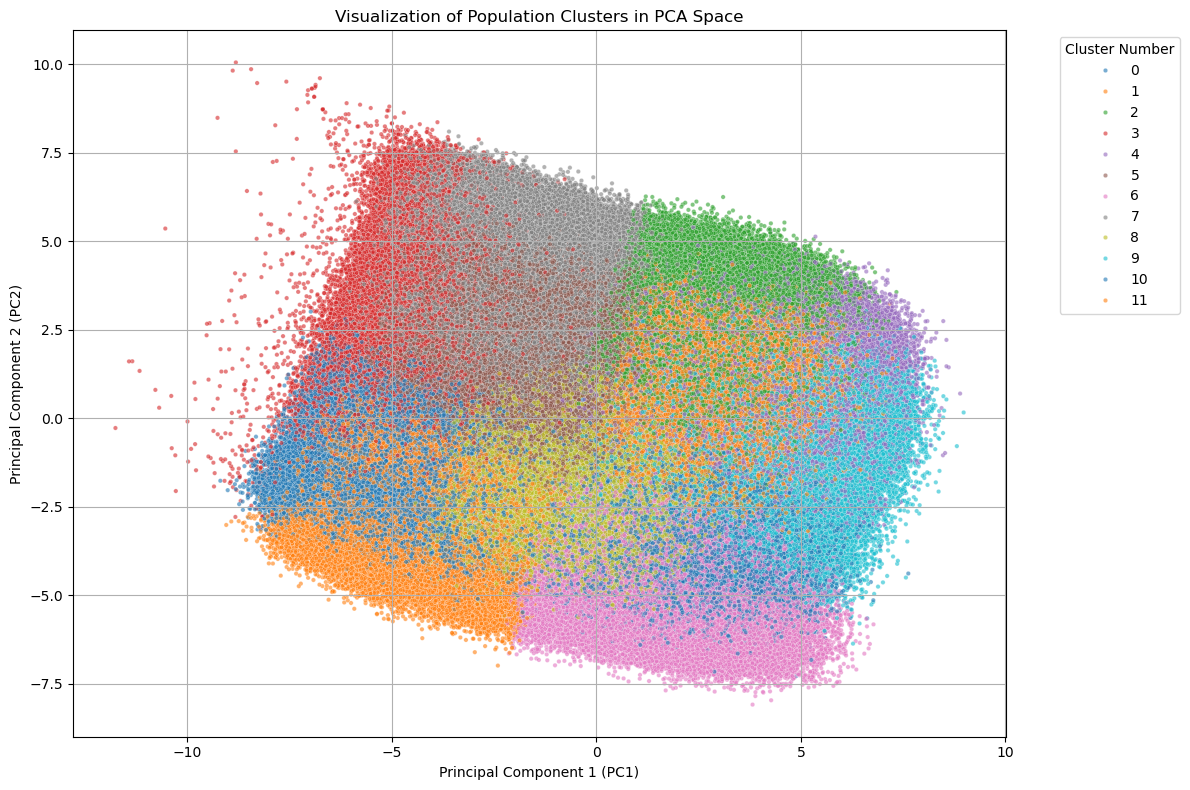

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

pca_df = pd.DataFrame(azdias_pca_reduced, columns=[f'PC{i+1}' for i in range(azdias_pca_reduced.shape[1])])
pca_df['CLUSTER'] = cluster_labels

# Plot using PC1 and PC2
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x='PC1', 
    y='PC2', 
    hue='CLUSTER', 
    palette='tab10', 
    data=pca_df, 
    legend='full', 
    s=10, alpha=0.6
)

plt.title("Visualization of Population Clusters in PCA Space")
plt.xlabel("Principal Component 1 (PC1)")
plt.ylabel("Principal Component 2 (PC2)")
plt.legend(title="Cluster Number", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

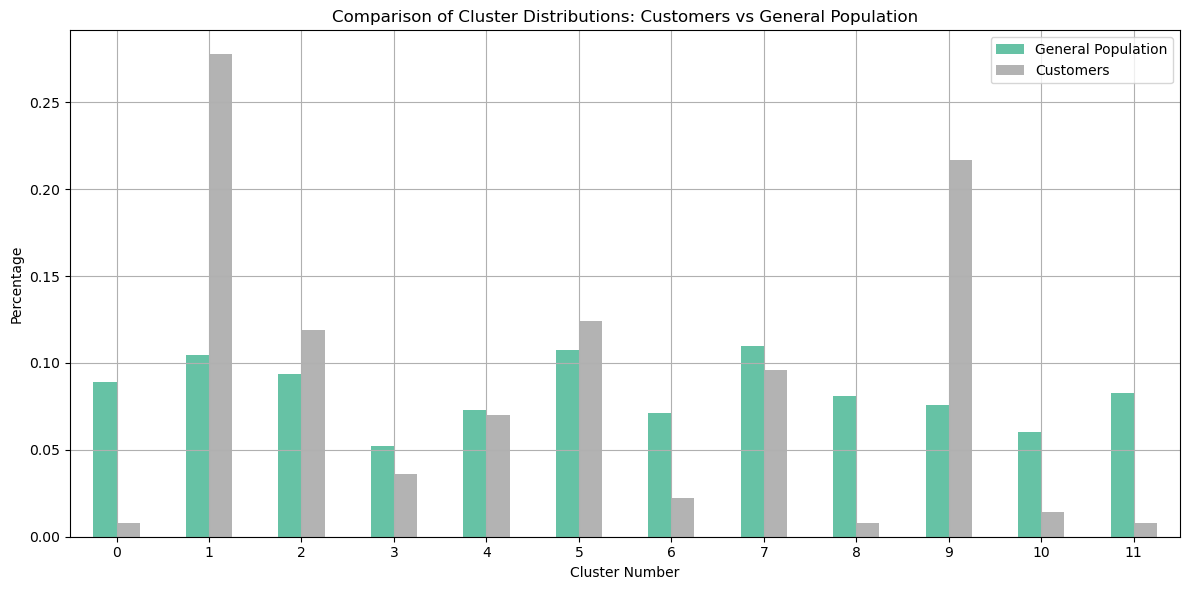

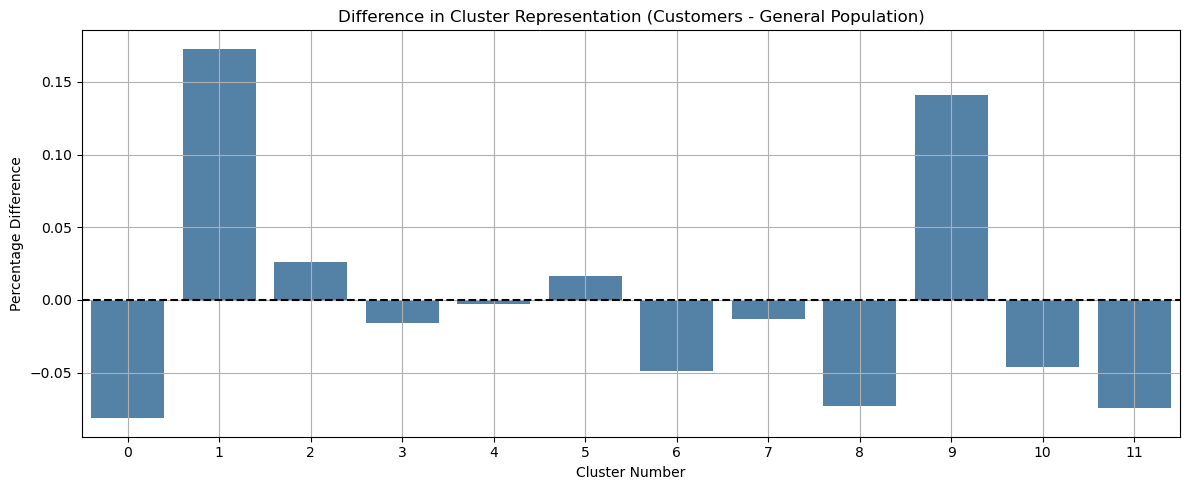

✅ Overrepresented clusters among customers:
         General_Population  Customers  Difference
Cluster                                           
1                  0.104866   0.277588    0.172722
9                  0.075566   0.216584    0.141018
2                  0.093389   0.119176    0.025787

❌ Underrepresented clusters among customers:
         General_Population  Customers  Difference
Cluster                                           
0                  0.089219   0.007749   -0.081469
11                 0.082572   0.007827   -0.074745
8                  0.080795   0.007827   -0.072967
6                  0.070951   0.022244   -0.048707
10                 0.060340   0.014431   -0.045909


In [ ]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Distribution in the general population
population_dist = pd.Series(cluster_labels).value_counts(normalize=True).sort_index()

# Distribution in the customer dataset
customer_dist = customers_final_df['CLUSTER'].value_counts(normalize=True).sort_index()

# Merge into a single DataFrame
dist_df = pd.DataFrame({
    'General_Population': population_dist,
    'Customers': customer_dist
})
dist_df.index.name = 'Cluster'
dist_df.fillna(0, inplace=True)  # handle missing clusters that appear only in one dataset
dist_df['Difference'] = dist_df['Customers'] - dist_df['General_Population']

# 2️⃣ Plot the distribution comparison
dist_df[['General_Population', 'Customers']].plot(kind='bar', figsize=(12, 6), colormap='Set2')
plt.title("Comparison of Cluster Distributions: Customers vs General Population")
plt.xlabel("Cluster Number")
plt.ylabel("Percentage")
plt.xticks(rotation=0)
plt.grid(True)
plt.legend(["General Population", "Customers"])
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 5))
sns.barplot(x=dist_df.index, y=dist_df['Difference'], color='steelblue')
plt.axhline(0, color='black', linestyle='--')
plt.title("Difference in Cluster Representation (Customers - General Population)")
plt.xlabel("Cluster Number")
plt.ylabel("Percentage Difference")
plt.grid(True)
plt.tight_layout()
plt.show()

# 4️⃣ Find overrepresented clusters
overrepresented_clusters = dist_df[dist_df['Difference'] > 0.02].sort_values('Difference', ascending=False)
print(" Overrepresented clusters among customers:")
print(overrepresented_clusters)

# 5️⃣ Find underrepresented clusters
underrepresented_clusters = dist_df[dist_df['Difference'] < -0.02].sort_values('Difference')
print("\n Underrepresented clusters among customers:")
print(underrepresented_clusters)


In [44]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?


# Attach cluster labels to your original data
population_clustered_df = azdias_final.copy()
population_clustered_df['CLUSTER'] = cluster_labels

# Filter data for a specific overrepresented cluster, e.g., Cluster 1
cluster_of_interest = 1
cluster_data = population_clustered_df[population_clustered_df['CLUSTER'] == cluster_of_interest]

# Get descriptive statistics for this cluster
print(f"✅ Descriptive statistics for cluster {cluster_of_interest} (overrepresented):\n")
print(cluster_data.describe())

# Optional: Compare to general population
print("\n✅ Comparison: General population descriptive statistics:\n")
print(azdias_final.describe())



✅ Descriptive statistics for cluster 1 (overrepresented):

       ALTERSKATEGORIE_GROB     ANREDE_KZ  CJT_GESAMTTYP  FINANZ_MINIMALIST  \
count          82585.000000  82585.000000   82585.000000       82585.000000   
mean               3.459054      1.003269       2.773494           4.597179   
std                0.589613      0.057085       1.426901           0.628448   
min                1.000000      1.000000       1.000000           1.000000   
25%                3.000000      1.000000       2.000000           4.000000   
50%                3.000000      1.000000       2.000000           5.000000   
75%                4.000000      1.000000       4.000000           5.000000   
max                4.000000      2.000000       6.000000           5.000000   

       FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  FINANZ_UNAUFFAELLIGER  \
count   82585.000000      82585.000000    82585.000000           82585.000000   
mean        1.607108          4.318980        1.769704             

In [46]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?


population_clustered_df = azdias_final.copy()
population_clustered_df['CLUSTER'] = cluster_labels

# Pick an underrepresented cluster (example: cluster 0)
under_cluster = 1

# Compute mean feature values for this cluster vs overall population
cluster_means = population_clustered_df[population_clustered_df['CLUSTER'] == under_cluster].mean()
population_means = azdias_final.mean()

# Put side by side in a DataFrame
comparison_df = pd.DataFrame({
    'Cluster_Mean': cluster_means,
    'Population_Mean': population_means
})

# Calculate the difference
comparison_df['Difference'] = comparison_df['Cluster_Mean'] - comparison_df['Population_Mean']

# Sort by difference to see where this cluster is most distinct
comparison_df.sort_values('Difference', ascending=False, inplace=True)

# Show top features higher in this cluster
print(f"🔍 Features most higher in cluster {under_cluster} vs general population:")
print(comparison_df.head(10))

# Show top features lower in this cluster
print(f"\n🔍 Features most lower in cluster {under_cluster} vs general population:")
print(comparison_df.tail(10))



🔍 Features most higher in cluster 1 vs general population:
                   Cluster_Mean  Population_Mean  Difference
KBA13_ANZAHL_PKW     673.213647       619.410060   53.803587
LP_STATUS_FEIN         8.075280         4.767790    3.307490
SEMIO_VERT             5.996876         4.273286    1.723590
FINANZ_MINIMALIST      4.597179         3.054451    1.542727
LP_STATUS_GROB         3.855434         2.450425    1.405009
MOBI_REGIO             4.042720         2.962588    1.080132
KBA05_ANTG1            2.479288         1.472497    1.006791
KBA05_GBZ              4.062057         3.148147    0.913910
FINANZ_VORSORGER       4.318980         3.435666    0.883314
INNENSTADT             5.426131         4.543815    0.882316

🔍 Features most lower in cluster 1 vs general population:
                     Cluster_Mean  Population_Mean  Difference
SEMIO_RAT                2.754072         3.892109   -1.138038
SEMIO_DOM                3.313616         4.558339   -1.244723
ORTSGR_KLS9           

### Discussion 3.3: Compare Customer Data to Demographics Data

The clustering analysis provides valuable insights into how the customer base of the mail-order company compares to the general population in Germany. By examining the relative distribution of clusters, we can identify segments of the population that are particularly overrepresented or underrepresented among the company’s customers.

Specifically, clusters such as **1 and 9** stand out as being significantly overrepresented in the customer data. These segments, which account for a disproportionately high share of customers compared to their presence in the general population, likely represent key target audiences for the company’s offerings. Profiling these clusters reveals that they may be characterized by specific demographic or lifestyle attributes—such as higher levels of consumer mobility, certain family structures, or financial attitudes—that align well with the company’s product lines and marketing strategies.

Conversely, clusters like **0, 8, and 11** are notably underrepresented among customers. These groups, despite forming a substantial portion of the general population, show relatively little engagement with the company. Analysis of these clusters suggests they may be demographically distinct, potentially including households with lower discretionary spending, different cultural or regional preferences, or other factors that make them less inclined to respond to the company’s typical marketing appeals.

Overall, this comparison highlights that the company’s current customer segments are not evenly distributed across the general population. Certain clusters clearly resonate more strongly with the company’s brand or products, while others do not. This understanding is crucial for refining marketing efforts, optimizing resource allocation, and potentially exploring tailored approaches to engage currently underserved segments—or deciding strategically to focus primarily on the segments that already demonstrate the highest affinity.

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.

In [ ]:
#---------------------------------------
#Thank you, Udacity. I'm Amr Adnan Badran.
#I recently got a job in Ramallah, Palestine.
#I'm really grateful for the experience I've gained.
#I was hired as an AI engineer.
#---------------------------------------